# Cooper & Priestley (2009) - Time-Varying Risk Premiums and the Output Gap

Notes:
- CPr originally use FB data for bond yields. Below we use FB, GSW and LW.
- CPr write that the Fed total industrial production index is frequently revised and therefore they gather "vintage" data themselves. This should be the dataset provided by Bauer. They note on p. 2804 that the revised (as of writing) data produces very similar results. 
- The below analysis will for each of FB, GSW and LW, compare in-sample results between using the Bauer dataset and updated data from the Fed. 
- FB will be used for the original CPr period of (1952:6-2003:12). GSW and LW data are only available from 1961, so the whole analysis will be rerun for the period (1961:6-2003:12) before rerunning on (1971:12-2023:12) as for CPo.

In [ ]:
from utils.data_processing import load_wrds_famabliss, load_fed_gsw_daily_yields, load_lw_daily_yields
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

start_date = pd.to_datetime('1952-06-01')
end_date = pd.to_datetime('2003-12-31')

indpro = pd.read_csv(r'data/CPr/INDPRO.csv', index_col=0, parse_dates=True, comment='%')  # Industrial Production Index data
# log_indpro = np.log(indpro).diff(12).dropna() # Annual log change
# log_indpro.index.name = 'Date'
log_indpro = np.log(indpro)
yt = log_indpro.loc[start_date:end_date].copy()
yt.index = yt.index + pd.offsets.MonthEnd(0) # Align index to end-of-month to match fb_yields (could also shift by one month)

yields = load_wrds_famabliss(file_path=r'data/WRDS_FamaBliss.csv', sample_start='1952-06-01', sample_end='2025-01-01')
yields = yields.rename(columns={'MCALDT': 'Date'})
yields.index.name = 'Date'

yields = load_lw_daily_yields(file_path=r'data/LW_daily.csv', start='1952-06-01', end='2025-01-01')
yields_train = yields.loc[start_date:end_date]

c:\Users\ulrik\OneDrive - NTNU\25-26_ Olav, Ulrik & Trine - Replikering\replikering_python\utils\data_processing.py:192: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  yields_monthly = yields_final.resample('M').last()


Loaded WRDS Fama-Bliss data: (775, 5)
Date range: 1952-06-30 00:00:00 to 2016-12-31 00:00:00
Available maturities: ['y1', 'y2', 'y3', 'y4', 'y5']


FileNotFoundError: [Errno 2] No such file or directory: 'data/LW_daily_yields.csv'

Fit regressions (1), (2), and (3) to construct gap factors

In [274]:
# Create the time trends for the regression
yt['t'] = range(1, len(yt)+1)
yt['t2'] = yt['t'] ** 2

# Run the regressions to get the output gap (the residuals)

# (1)
quadratic_model = smf.ols(formula='INDPRO ~ t + t2', data=yt).fit()

# Create a new variable for the trend after the break
# It's 0 before t1, and (t - t1) after t1.
breakpoint_date = pd.to_datetime('1977-06-30')
t1 = yt.loc[breakpoint_date, 't']
yt['break_trend'] = (yt['t'] - t1).clip(lower=0)

# (2)
breakpoint_model = smf.ols(formula='INDPRO ~ t + break_trend', data=yt).fit()

# (3)
linear_model = smf.ols(formula='INDPRO ~ t', data=yt).fit()

gap_q = quadratic_model.resid.rename('gap_q')
gap_b = breakpoint_model.resid.rename('gap_b')
gap_l = linear_model.resid.rename('gap_l')

# Load the CBO and Bauer gaps:
cbo_data = pd.read_csv(r'data/CPr/CBO_Quarterly_January2025.csv', index_col=0).rename(columns={'output_gap': 'gap_cbo'})
cbo_data.index = pd.to_datetime(cbo_data.index)
cbo_data = cbo_data.resample('ME').ffill()  # Forward fill to monthly frequency
gap_cbo = cbo_data['gap_cbo']
gap_cbo = gap_cbo[start_date:end_date]/100 # Crop and convert to decimal

bauer_gap = pd.read_csv(r'data/CPr/bauer_cpr_gap.csv', index_col=0, parse_dates=True).rename(columns={'gap': 'gap_bauer'})
bauer_gap = bauer_gap[start_date:end_date]

gaps = pd.concat([gap_q, gap_b, gap_l, gap_cbo, bauer_gap], axis=1)*100

C:\Users\ulrik\AppData\Local\Temp\ipykernel_34008\1253172225.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cbo_data.index = pd.to_datetime(cbo_data.index)


Heatmap of gaps:

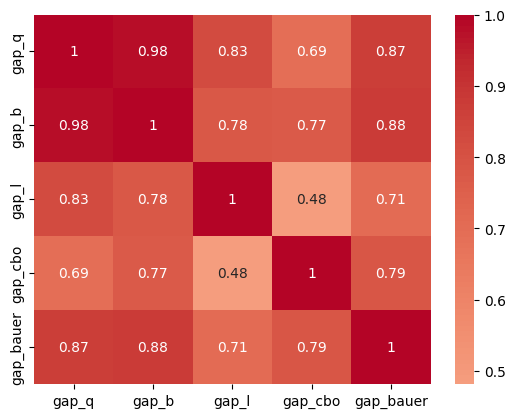

In [276]:
import seaborn as sns

sns.heatmap(gaps.corr(), annot=True, cmap='coolwarm', center=0)
plt.show()

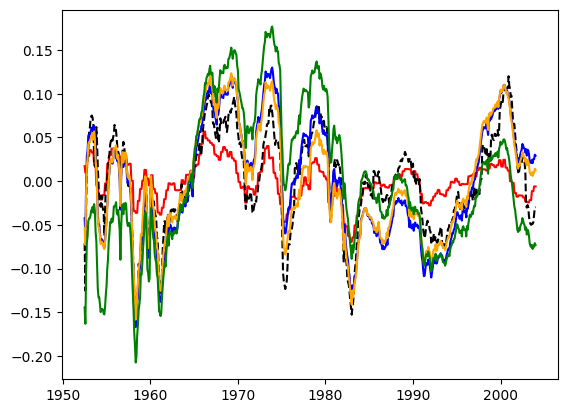

In [277]:
# plot gaps over time:

plt.plot(gap_cbo, label='CBO Gap', color='red')
plt.plot(bauer_gap, label='Bauer Gap', color='black', linestyle='--')
plt.plot(gap_q, label='Quadratic Trend Gap', color='blue')
plt.plot(gap_b, label='Break Trend Gap', color='orange')
plt.plot(gap_l, label='Linear Trend Gap', color='green')
plt.show()

# Replicating "4. Bond Returns":

In [278]:
from utils.yield_processing import calculate_excess_returns, create_cochrane_piazzesi_factor

yields_for_cp_factor = yields[yields.index <= '2005-01-01']
cp_factor = pd.DataFrame(create_cochrane_piazzesi_factor(yields_for_cp_factor)['cp_factor']).rename(columns={'CP': 'cp_factor'})*100
yield_xr = calculate_excess_returns(yields_train, maturities=[2,3,4,5])*100

In [296]:
yx = pd.concat([yield_xr, gaps.shift(2), cp_factor.shift(1)], axis=1).dropna()
# 'gap_q', 'gap_b', 'gap_l', 'gap_cbo', 'gap_bauer'
# orthogonalize by regressing CP on gap_cbo and taking the residuals
cp_ortho_model = smf.ols(formula='cp_factor ~ gap_cbo', data=yx).fit()
yx['cp_factor_ortho'] = cp_ortho_model.resid.loc[yx.index]

smf.ols(formula='xr5 ~ gap_cbo + cp_factor_ortho', data=yx, ).fit(cov_type='HAC', cov_kwds={'maxlags':22}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xr5   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     6.247
Date:               tor., 02 okt 2025   Prob (F-statistic):            0.00206
Time:                        15:35:51   Log-Likelihood:                -1820.6
No. Observations:                 605   AIC:                             3647.
Df Residuals:                     602   BIC:                             3660.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6313      0.589      1.072      0.284      -0.523       1.785
gap_cbo            -0.3859      0.232     -1.665      0.096      -0.840       0.068
cp_factor_ortho     1.4352      0.430      3.341      0.001       0.593       2.277
==============================================================================
Omnibus:                       12.593   Durbin-Watson:                   0.252
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.183
Skew:                          -0.275   Prob(JB):                     0.000832
Kurtosis:                       3.511   Cond. No.                         2.25
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 22 lags and without small sample correction
"""

Perform robustness check using PCs

In [292]:
# perform pca on yields and use pcs instead of cp factor
from statsmodels.multivariate.pca import PCA
pca = PCA(yields_train.dropna(), ncomp=3)
pca_df = pd.DataFrame(pca.factors, index=yields_train.dropna().index)*100
pca_regression = smf.ols(
    formula='xr5 ~ cp_factor + gap_cbo + comp_0 + comp_1 + comp_2',
    data=yx.join(pca_df, how='inner')
    ).fit(cov_type='HAC', cov_kwds={'maxlags':22})
pca_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xr5   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     5.973
Date:               tor., 02 okt 2025   Prob (F-statistic):           2.10e-05
Time:                        15:35:02   Log-Likelihood:                -1793.2
No. Observations:                 605   AIC:                             3598.
Df Residuals:                     599   BIC:                             3625.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0423      0.727     -0.058      0.954      -1.467       1.383
cp_factor      0.9892      0.497      1.992      0.046       0.016       1.963
gap_cbo        0.4483      0.269      1.668      0.095      -0.079       0.975
comp_0         0.1031      0.175      0.590      0.555      -0.239       0.446
comp_1        -0.4313      0.161     -2.676      0.007      -0.747      -0.115
comp_2         0.1875      0.091      2.063      0.039       0.009       0.366
==============================================================================
Omnibus:                       20.446   Durbin-Watson:                   0.302
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.669
Skew:                          -0.333   Prob(JB):                     1.62e-06
Kurtosis:                       3.783   Cond. No.                         6.60
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 22 lags and without small sample correction
"""